# Dask Bag

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "Map-Reduce"
* https://docs.dask.org/en/latest/bag.html
* Jesse C. Daniel. Data Science with Python and Dask. 
* https://docs.dask.org/en/stable/generated/dask.bag.read_text.html
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.distinct.html
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.count.html
* https://www.nltk.org/_modules/nltk/tokenize/regexp.html
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.mean.html
* https://www.crummy.com/software/BeautifulSoup/bs4/doc/
* https://docs.dask.org/en/stable/generated/dask.bag.Bag.frequencies.html
* https://pypi.org/project/wordcloud/

## Лабораторная работа 9

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `pandas` и `dask`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов `numpy`, структур `pandas` или структур `dask` используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

В ходе выполнения все операции вычислений проводятся над `dask.bag` и средствами пакета `dask`, если в задании не сказано обратного. Переход от `dask.bag` к `pd.DataFrame` возможен исключительно для демонстрации результата в конце решения задачи. Если в задаче используются результаты выполнения предыдущих задач, то подразумевается, что вы используете результаты в виде `dask.bag` (то есть то, что было получено до вызова `compute`, а не после).

<p class="task" id="1"></p>

1\. В файлах архива `reviews_full.zip` находятся файлы, содержащие информацию об отзывах к рецептам в формате JSON Lines. Отзывы разделены на файлы в зависимости от оценки (например, в файле `reviews_1.json` находятся отзывы с оценкой 1). Считайте файлы из этого архива (предварительно разархивировав) в виде `dask.bag`. Преобразуйте текстовое содержимое файлов с помощью модуля `json`. Выведите на экран первые 5 элементов полученного `bag`.

Примечание: при необходимости вы можете разархивировать архив любым удобным способом.

In [1]:
import dask.bag as db
import json
import re

In [2]:
b = db.read_text(urlpath="reviews_full/reviews_*.json").map(json.loads)
b.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.'},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten'},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will be making this often.'},
 {'u

<p class="task" id="2"></p>

2\. Модифицируйте функцию разбора JSON таким образом, чтобы в каждый словарь c информацией об отзыве добавить ключ `rating`. Значение получите на основе названия файла (см. аргумент `include_path` функции `read_text`), использовав для этого регулярное выражение. При создании `bag` разбейте набор данных на сегменты размером 128 MiB (см. аргумент `blocksize`).  Выведите на экран первые 5 элементов полученного `bag` и количество сегментов в нем. 

In [3]:
def my_loader(data):
    json_str, path = data
    file_number = re.findall('reviews_([0-5]).json', path)
    json_obj = json.loads(json_str)
    json_obj["rating"] = int(file_number[0])
    return json_obj

b_bag = db.read_text(urlpath="reviews_full/*.json", blocksize='128 MiB', include_path=True).map(my_loader)
b_bag.take(5)

({'user_id': 452355,
  'recipe_id': 292657,
  'date': '2016-05-08',
  'review': 'WOW!!! This is the best. I have never been able to make homemade enchiladas that taste like the Mexican restaurants. I made this last night for my family and they said they will never have enchiladas at the Mexican Restaurants again. Thanks for sharing.',
  'rating': 0},
 {'user_id': 329304,
  'recipe_id': 433404,
  'date': '2006-06-14',
  'review': 'This was good but the dressing needed something and I found it to be a little too sweet, next time I will experiment with some garlic and herbs and reduce the sugar slightly, thanks for sharing kcdlong!...Kitten',
  'rating': 0},
 {'user_id': 227932,
  'recipe_id': 2008187,
  'date': '1985-11-19',
  'review': 'Very good,it was a hit for my family. I used 6 cloves of garlic and had 1 lb beef and  Johnsonville sausage,1/2 lb hot and  1/2 lb honey garlic( which I wanted to use). That was a perfect combo for us. The sausage gave it nice flavor No guestion , I will

In [4]:
b_bag.npartitions

25

<p class="task" id="3"></p>

3\. Посчитайте, сколько различных пользователей оставляли отзывы. Выведите это количество на экран.

In [5]:
b_bag.distinct(key='user_id').count().compute()

226570

<p class="task" id="4"></p>

4\. Создайте версию `bag` из задания 2, в которой сохранены только отзывы, оставленные в 2014 и 2015 годах. Посчитайте и выведите на экран долю, которую составляют отзывы, оставленные в 2014 и 2015 году, среди всех отзывов.

In [6]:
# Определяем функцию-фильтр для отбора отзывов, оставленных в 2014 или 2015 году
def filter_reviews_by_year(review):
    year = int(review["date"][:4])
    return year == 2014 or year == 2015

# Создаем новый bag, содержащий только отзывы, оставленные в 2014 и 2015 годах
filtered_bag = b_bag.filter(filter_reviews_by_year)

# Подсчитываем долю отзывов, оставленных в 2014 и 2015 годах
filtered_count = filtered_bag.count().compute()
total_count = b_bag.count().compute()
ratio = filtered_count / total_count

# Выводим результат на экран
print(f"Доля отзывов, оставленных в 2014 и 2015 годах: {ratio}")
print(filtered_count)

Доля отзывов, оставленных в 2014 и 2015 годах: 0.08117811237929945
735274


<p class="task" id="5"></p>

5\. Для отзывов, оставленных в мае 2013 года, выполните предобработку: 
   * приведите строки к нижнему регистру;
   * обрежьте пробельные символы в начале и конце строки;
   * удалите все символы, кроме английских букв и пробелов.
   
Посчитайте и выведите на экран среднюю длину этих отзывов после предобработки. Если текстовое содержимое отзыва отсутствует, считайте, что длина отзыва равна нулю.

In [7]:
pattern = re.compile('[^a-z ]+')

In [8]:
def filter_reviews_by_year(review):
    year = review["date"][:7]
    return year == '2013-05'

def my_preprocessing(item):
    current_str = item["review"].lower().strip()
    item["review"] = re.sub(pattern, '', current_str)
    return item

filtered_bag_2013 = b_bag.filter(filter_reviews_by_year)

d_bag = filtered_bag_2013.map(my_preprocessing)

lengths = d_bag.map(lambda item: len(item["review"]))
mean_length = lengths.mean().compute()
print(f"Средняя длина отзывов:{mean_length}")

Средняя длина отзывов:268.9917584273458


<p class="task" id="6"></p>

6\. В файле `food.txt` представлен список из 329 ссылок на страницы Википедии, посвященные различным блюдам. Получив основное текстовое содержимое этих страниц, выясните, какие топ-30 слов используются в этих статьях чаще всего. Выведите на экран эти слова и их частоты.

Для разбиения текста на слова воспользуйтесь токенизатором `tokenizer`. В качестве препроцессинга приведите все слова к нижнему регистру и удалите стоп-слова, входящие в список английских стоп-слов из `nltk`.

При решении задачи не используйте параллельных вычислений. Измерьте время выполнения решения.

Примечание: под основным содержимым страницы подразумевается содержимое тега `div`, имеющего класс `mw-parser-output`.

In [9]:
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

In [10]:
%%time

links = open('food.txt').read().splitlines()
    
def get_tokens(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    content = soup.find("div", {"class": "mw-parser-output"})
    text = content.text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return filtered_tokens

all_tokens = []
for link in links:
    tokens = get_tokens(link)
    all_tokens.extend(tokens)

top_30 = Counter(all_tokens).most_common(30)
top_30

Wall time: 1min 46s


[('nasi', 8514),
 ('goreng', 4646),
 ('ayam', 4485),
 ('sate', 3411),
 ('mi', 3245),
 ('soto', 2761),
 ('pizza', 2728),
 ('roti', 2512),
 ('indonesian', 2486),
 ('rice', 2442),
 ('edit', 1983),
 ('es', 1711),
 ('kari', 1708),
 ('ikan', 1707),
 ('retrieved', 1702),
 ('food', 1674),
 ('babi', 1671),
 ('tahu', 1586),
 ('rujak', 1528),
 ('cheese', 1522),
 ('bubur', 1420),
 ('teh', 1358),
 ('sayur', 1328),
 ('soup', 1322),
 ('dishes', 1318),
 ('bakar', 1270),
 ('list', 1244),
 ('sambal', 1243),
 ('lumpia', 1228),
 ('pindang', 1219)]

<p class="task" id="7"></p>

7\. Решите задачу 6, распараллелив процесс получения текста страницы из Википедии при помощи `dask.bag`.Выведите на экран полученный список топ-30 слов и их частоты. Для подсчета частот воспользуйтесь методом `Bag.frequencies`. Измерьте время выполнения решения.

Подсказка: обратите внимание на количество сегментов в `Bag`, который вы создали. 

In [11]:
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import dask.bag as db

In [12]:
%%time

links = open('food.txt').read().splitlines()

def get_tokens(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    content = soup.find("div", {"class": "mw-parser-output"})
    text = content.text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    return filtered_tokens

bag = db.from_sequence(links)
tokens = bag.map(get_tokens).flatten()
top_30 = tokens.frequencies().topk(30, lambda x: x[1]).compute()

top_30

Wall time: 17.5 s


[('nasi', 8514),
 ('goreng', 4646),
 ('ayam', 4485),
 ('sate', 3411),
 ('mi', 3245),
 ('soto', 2761),
 ('pizza', 2728),
 ('roti', 2512),
 ('indonesian', 2486),
 ('rice', 2442),
 ('edit', 1983),
 ('es', 1711),
 ('kari', 1708),
 ('ikan', 1707),
 ('retrieved', 1702),
 ('food', 1673),
 ('babi', 1671),
 ('tahu', 1586),
 ('rujak', 1528),
 ('cheese', 1522),
 ('bubur', 1420),
 ('teh', 1358),
 ('sayur', 1328),
 ('soup', 1322),
 ('dishes', 1318),
 ('bakar', 1270),
 ('list', 1244),
 ('sambal', 1243),
 ('lumpia', 1228),
 ('pindang', 1219)]

<p class="task" id="8"></p>

8\. Визуализируйте результат, полученный в задаче 6 или 7, в виде облака слов. Для генерации облака слов вы можете воспользоваться пакетом [wordcloud](https://pypi.org/project/wordcloud/). Обратите внимание, что размер слова на визуализации должен зависеть от частоты использования этого слова.

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

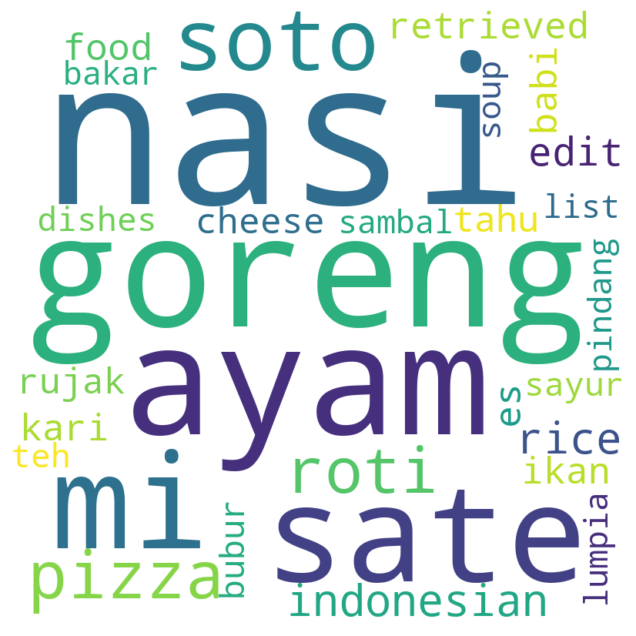

In [14]:
wordcloud_dict = dict(top_30)
wordcloud = WordCloud(width=800, height=800, background_color='white')
wordcloud.generate_from_frequencies(wordcloud_dict)

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()